<a href="https://colab.research.google.com/github/CarbonEdge/KaggleToxicityTwitter/blob/master/EPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joe1dataset","key":"6b0fb27ea8d287ee06e3820f3e52ea98"}'}

In [15]:
ls -lha kaggle.json

-rw-r--r-- 1 root root 67 May 19 17:31 kaggle.json


In [0]:
#file configuration

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
#this is how you download the kaggle files

!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

  0% 0.00/221k [00:00<?, ?B/s]
100% 221k/221k [00:00<00:00, 69.4MB/s]
 41% 5.00M/12.1M [00:00<00:00, 42.9MB/s]
100% 12.1M/12.1M [00:00<00:00, 77.0MB/s]
 97% 265M/273M [00:01<00:00, 141MB/s]
100% 273M/273M [00:01<00:00, 143MB/s]


In [0]:
import zipfile

sub = zipfile.ZipFile('sample_submission.csv.zip') 
train = zipfile.ZipFile('train.csv.zip') 
test = zipfile.ZipFile('test.csv.zip') 

train_df = pd.read_csv(train.open('train.csv'))
test_df = pd.read_csv(test.open('test.csv'))

In [26]:
#ls
train_len, test_len = len(train_df.index), len(test_df.index)
print(f'train size: {train_len}, test size: {test_len}')

train size: 1804874, test size: 97320


In [27]:
train_df.head()


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [28]:
# its always a good idea to count the amount of missing values before diving into any analysis
# Lets also see how many missing values (in percentage) we are dealing with
miss_val_train_df = train_df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

In [0]:
# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']
# getting the dataframe with identities tagged
train_labeled_df = train_df.loc[:, ['target'] + identities ].dropna()
# lets define toxicity as a comment with a score being equal or .5
# in that case we divide it into two dataframe so we can count toxic vs non toxic comment per identity
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]


In [0]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.where(train_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(train_labeled_df == 0, other = 1).sum()

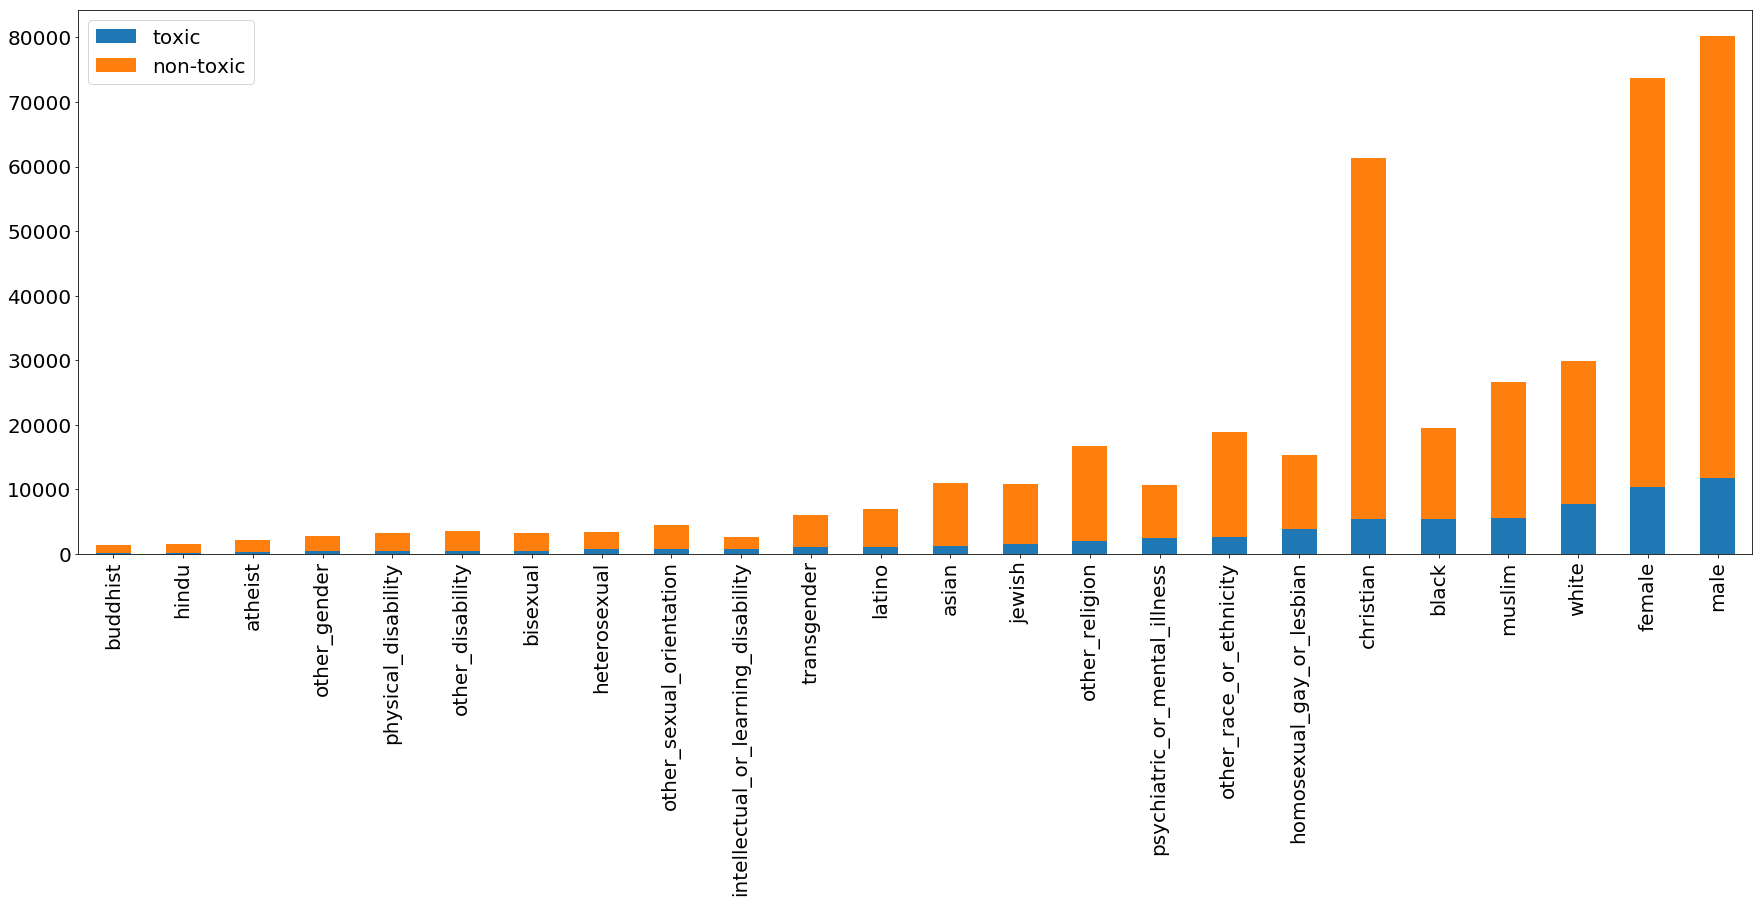

In [33]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

In [0]:
#
# The diagram above is certainly one way of looking at our data. However, it is missing the complete picture because we are not using two things. 
# First, for each example we have a score (target) of how toxic the comment is. Second, each identity also has a value between 0 to 1 to identify how much they have been targeted. 
# We can use this two aspects to our advantage and see which identities are more frequently related to toxic comments.

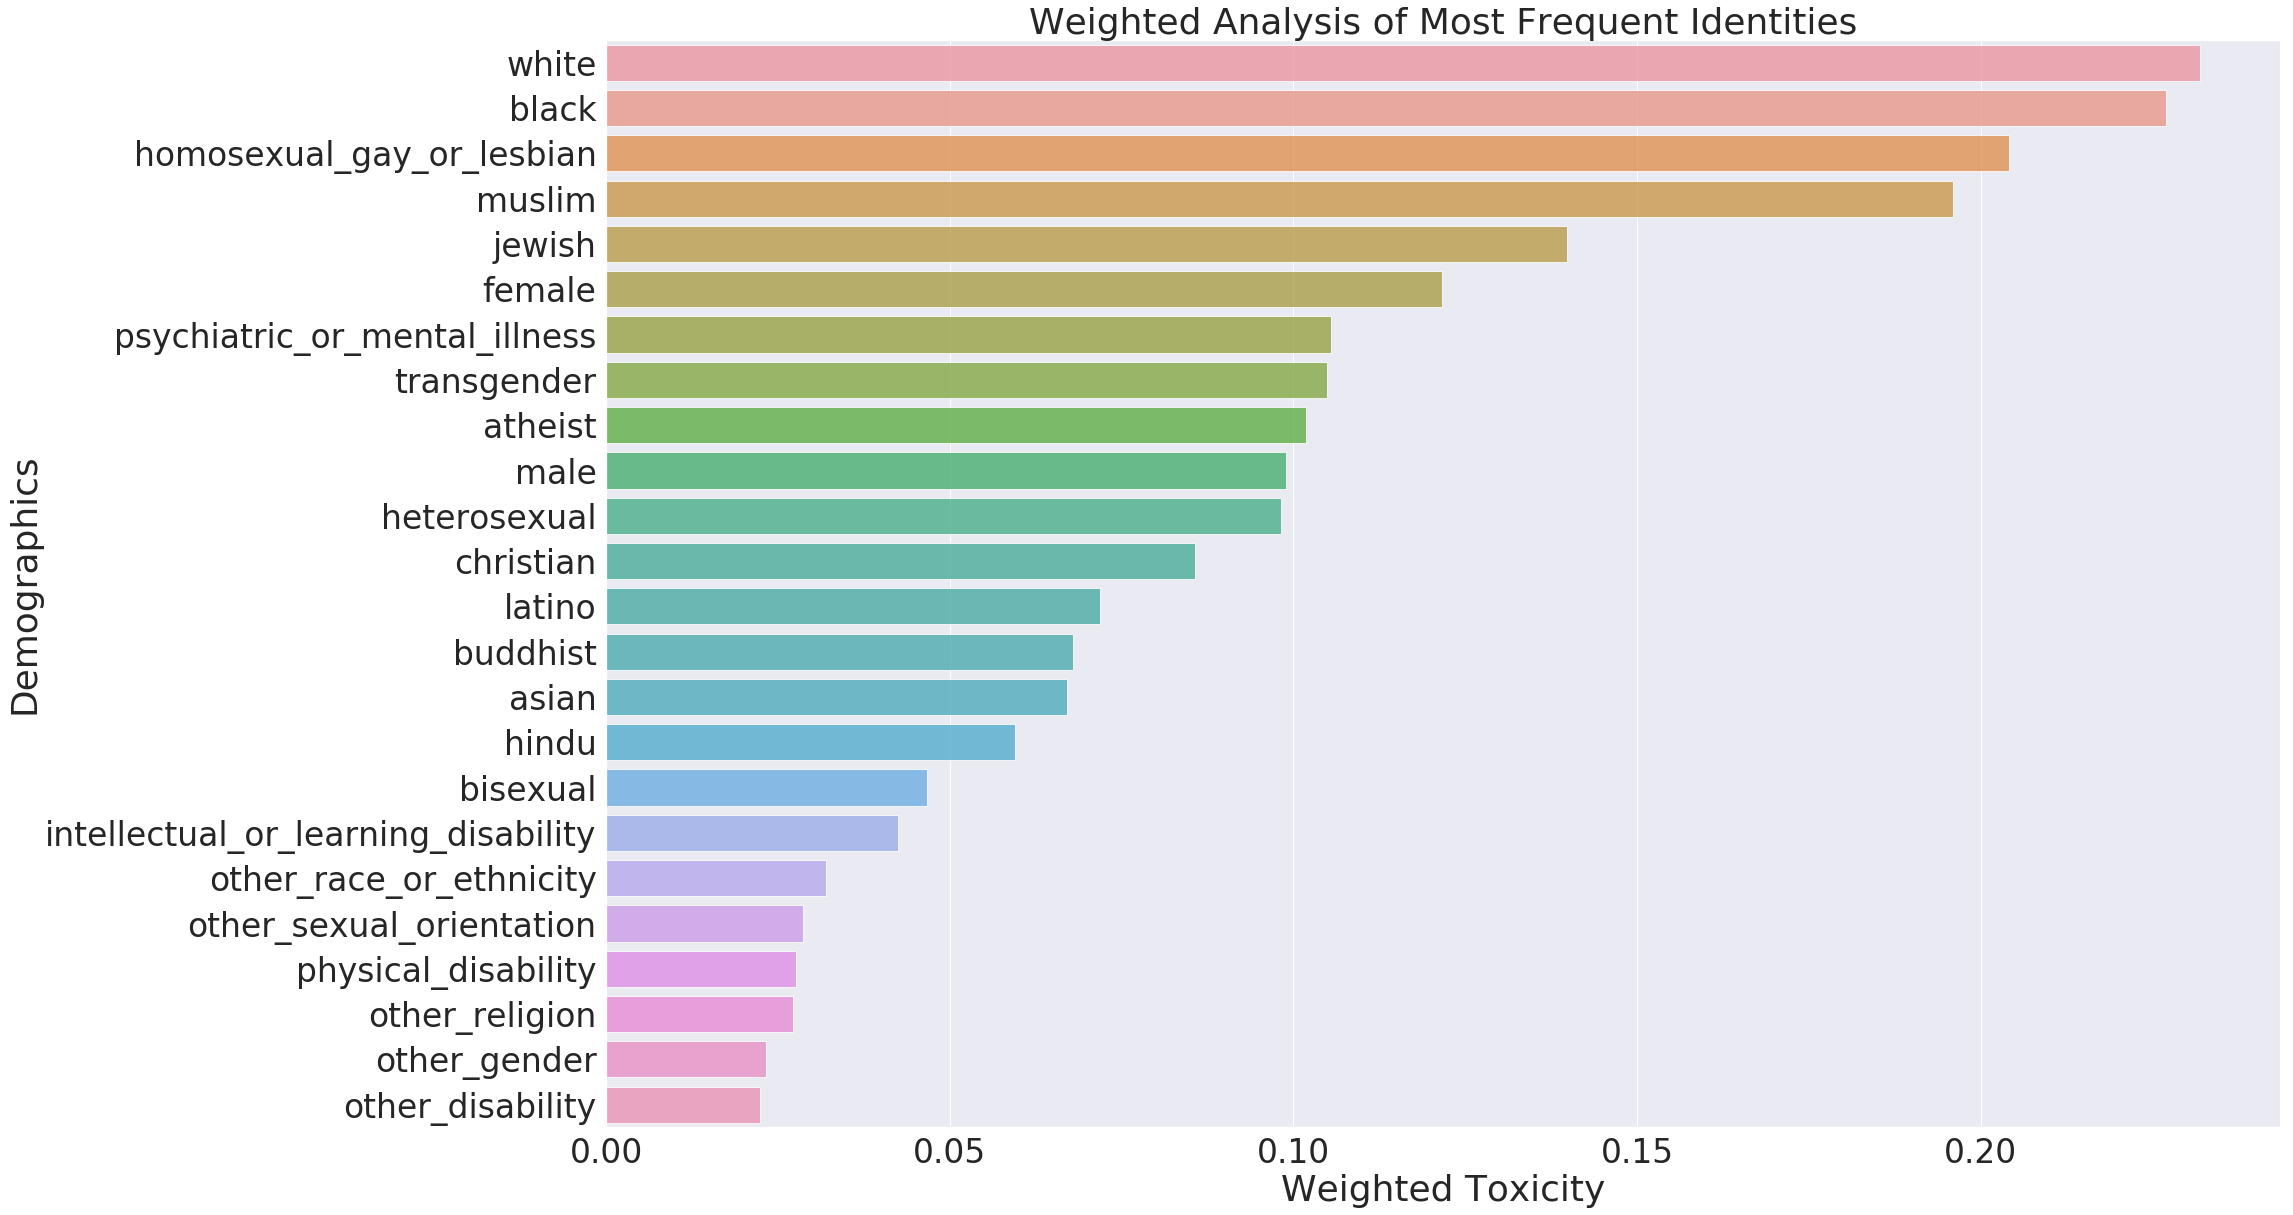

In [34]:
# First we multiply each identity with the target
weighted_toxic = train_labeled_df.iloc[:, 1:].multiply(train_labeled_df.iloc[:, 0], axis="index").sum() 
# changing the value of identity to 1 or 0 only and get comment count per identity group
identity_label_count = train_labeled_df[identities].where(train_labeled_df == 0, other = 1).sum()
# then we divide the target weighted value by the number of time each identity appears
weighted_toxic = weighted_toxic / identity_label_count
weighted_toxic = weighted_toxic.sort_values(ascending=False)
# plot the data using seaborn like before
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values , y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxicity')
plt.title('Weighted Analysis of Most Frequent Identities')
plt.show()

In [0]:
# lets take the dataset with identitiy tags, created date, and target column
with_date_df = train_df.loc[:, ['created_date', 'target'] + identities].dropna()
# next we will create a weighted dataframe for each identity tag (like we did before)
# first we divide each identity tag with the total value it has in the dataset
weighted_df = with_date_df.iloc[:, 2:] / with_date_df.iloc[:, 2:].sum()
# then we multiplty this value with the target 
target_weighted_df = weighted_df.multiply(with_date_df.iloc[:, 1], axis="index")
# lets add a column to count the number of comments
target_weighted_df['comment_count'] = 1
# now we add the date to our newly created dataframe (also parse the text date as datetime)
target_weighted_df['created_date'] = pd.to_datetime(with_date_df['created_date'].apply(lambda dt: dt[:10]))
# now we can do a group by of the created date to count the number of times a identity appears for that date
identity_weight_per_date_df = target_weighted_df.groupby(['created_date']).sum().sort_index()

In [0]:
# lets group most of the identities into three major categories as follows for simplified analysis
races = ['black','white','asian','latino','other_race_or_ethnicity']
religions = ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'jewish','other_religion']
sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

Text(0, 0.5, 'Weighted Toxic Score')

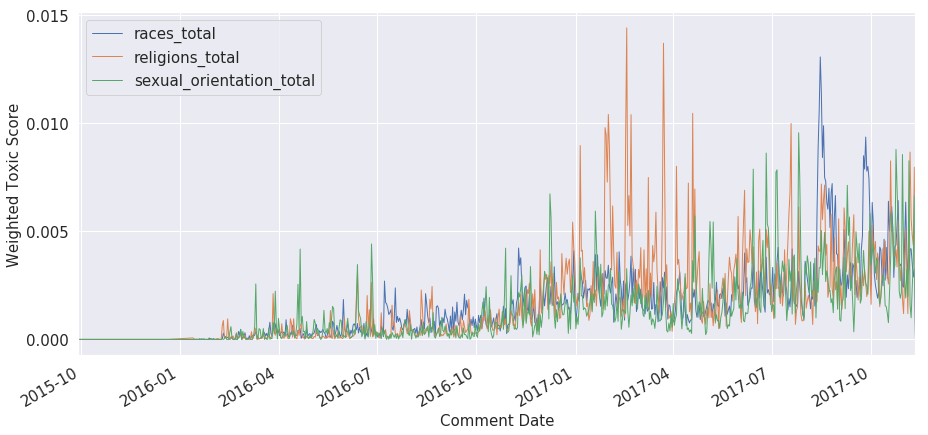

In [38]:
# lets create a column to aggregate our weighted toxicity score per identity group
identity_weight_per_date_df['races_total'] = identity_weight_per_date_df[races].sum(axis=1)
identity_weight_per_date_df['religions_total'] = identity_weight_per_date_df[religions].sum(axis=1)
identity_weight_per_date_df['sexual_orientation_total'] = identity_weight_per_date_df[sexual_orientation].sum(axis=1)
# and then plot a time-series line plot per identity group
identity_weight_per_date_df[['races_total', 'religions_total', 'sexual_orientation_total']].plot(figsize=(15,7), linewidth=1, fontsize=15) 
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Weighted Toxic Score', fontsize=15)

In [0]:
#1.At first sight, what a sad graph to look at. First of all, there are many many spikes in our dataset, so we should zoom into each identity per group to see more. Furthermore, 
#2. we notice a trend of more toxic messages as time goes by. What a depressing sight :( However, we should keep in mind that the distribution of data over the timeline is probably skewed. Lets check it out.

Text(0, 0.5, 'Total Comments')

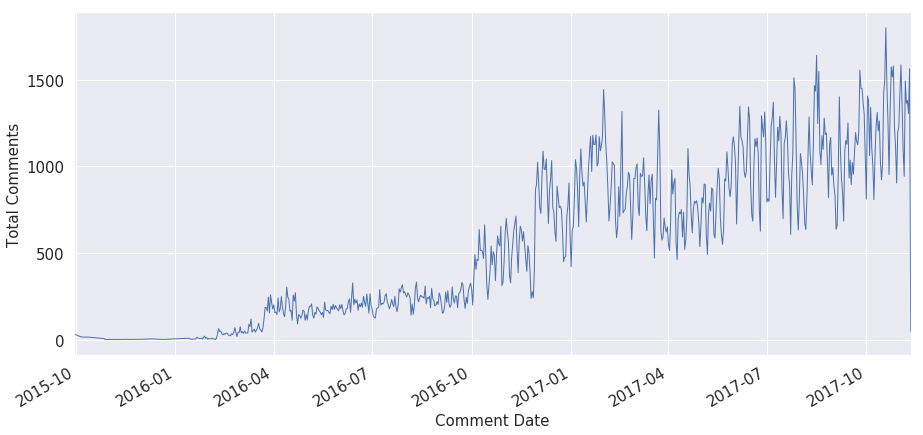

In [40]:
identity_weight_per_date_df['comment_count'].plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.xlabel('Comment Date', fontsize = 15)
plt.ylabel('Total Comments', fontsize = 15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

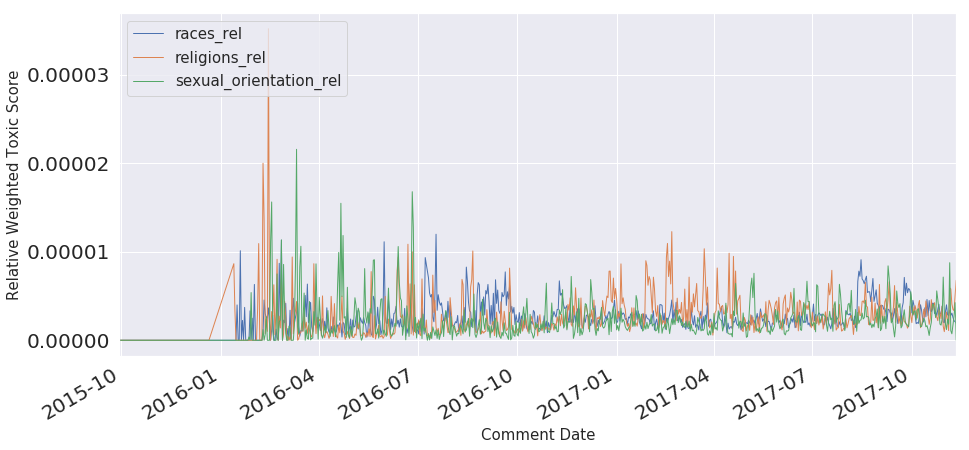

In [41]:
# lets divide by the comment count for the date to get a relative weighted toxic score
identity_weight_per_date_df['races_rel'] = identity_weight_per_date_df['races_total'] / identity_weight_per_date_df['comment_count']
identity_weight_per_date_df['religions_rel'] = identity_weight_per_date_df['religions_total'] / identity_weight_per_date_df['comment_count']
identity_weight_per_date_df['sexual_orientation_rel'] = identity_weight_per_date_df['sexual_orientation_total']  / identity_weight_per_date_df['comment_count']
# now lets plot the data
identity_weight_per_date_df[['races_rel', 'religions_rel', 'sexual_orientation_rel']].plot(figsize=(15,7), linewidth=1, fontsize=20) 
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

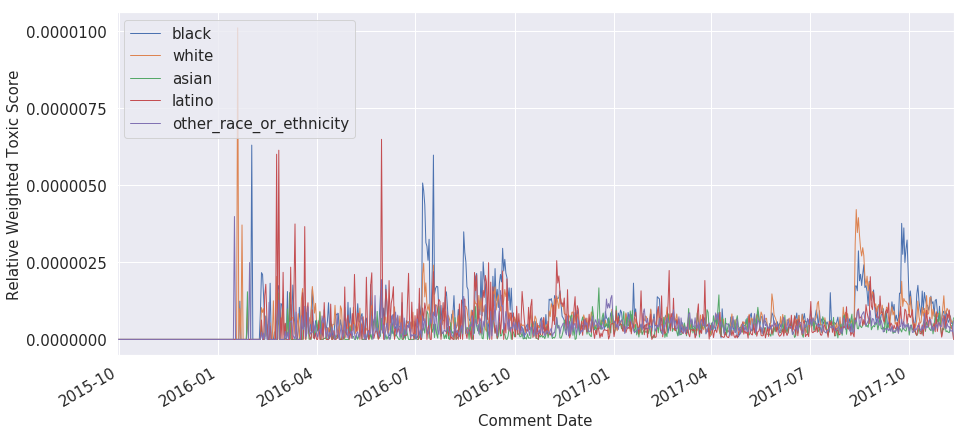

In [42]:
# lets plot relative weighted toxic score for each identity of races
identity_weight_per_date_df[races].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

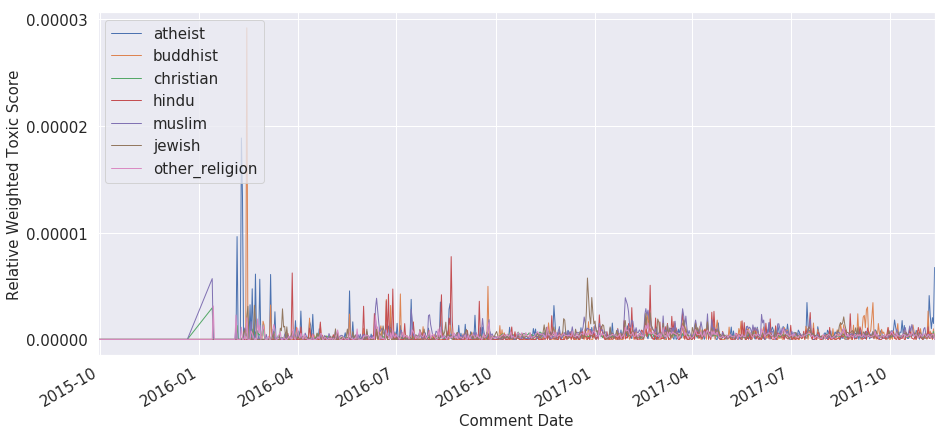

In [43]:
# lets plot relative weighted toxic score for each identity of religions
identity_weight_per_date_df[religions].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=15)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

Text(0, 0.5, 'Relative Weighted Toxic Score')

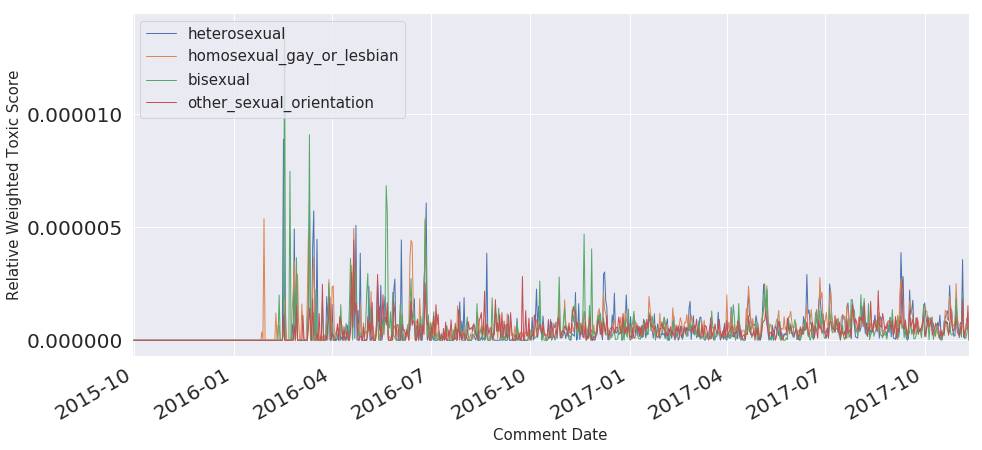

In [44]:
# lets plot relative weighted toxic score for each identity of sexual orientation
identity_weight_per_date_df[sexual_orientation].div(identity_weight_per_date_df['comment_count'], axis=0).plot(figsize=(15,7), linewidth=1, fontsize=20)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

In [0]:
# lets import the algorithm source https://www.kaggle.com/ekhtiar/tutorial-jigsaw-unintended-bias-basic-eda
from scipy.signal import argrelextrema

# we will store all the different datapoints in the following dataframe
peaks_df = pd.DataFrame()

# first we loop through all the different identities we are interested in
for col in races + religions + sexual_orientation:
    # we pass the values through the algorithm to get an index of the rel. maximums 
    _max_index = argrelextrema(identity_weight_per_date_df[col].values, np.greater, order=15)
    # we use the index returned to create a dataframe of the values for those index. in this case 
    # we are interested in the created date and the score, notice how the dataframe needs to be 
    # transformed because of the orientation of the arrays we started off with
    col_peaks_df = pd.DataFrame(data = [identity_weight_per_date_df.index[_max_index], identity_weight_per_date_df[col].values[_max_index]]).T
    col_peaks_df.columns = ['created_date','score']
    # we create a new column labeling the identity so we can track which peak came from which identity
    col_peaks_df['identity'] = col
    # and we keep appending to our main dataframe 
    peaks_df = peaks_df.append(col_peaks_df)
# lets set identity as our index and we are done
peaks_df = peaks_df.set_index('identity')

# to count the number of days from the first comment, we take our labeled data and convert the created date column
comments_with_date_df = train_df.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()
comments_with_date_df['created_date'] = pd.to_datetime(with_date_df['created_date'].apply(lambda dt: dt[:10]))
comments_with_date_df['comment_count'] = 1




In [0]:
# calculate days from first comment
first_dt = min(comments_with_date_df['created_date'].values)
last_dt = max(comments_with_date_df['created_date'].values)
peaks_df['days_from_first'] = (peaks_df['created_date'] - first_dt).dt.days

In [47]:
# here is a peak at what our peaks_df looks like
peaks_df.head()

,created_date,score,days_from_first
identity,,,
black,2016-02-10 00:00:00,0.000138761,134
black,2016-03-28 00:00:00,0.000249878,181
black,2016-05-21 00:00:00,0.000300618,235
black,2016-07-08 00:00:00,0.00146737,283
black,2016-08-15 00:00:00,0.000894331,321


In [0]:
# lets create a function that returns the peaks dataframe for a given identity
# we also want to get the number of toxic comments made against that identity in the dataframe
def get_identity_peaks_df(identity, peaks_df, comments_with_date_df):
    # select subset and sort
    identity_peaks_df = peaks_df[peaks_df.index==identity].sort_values(by='score', ascending=False)
    # change the score type to float
    identity_peaks_df['score'] = identity_peaks_df.score.astype(float)
    # use created date as the index so we can join over in later step
    identity_peaks_df = identity_peaks_df.set_index('created_date')
    # calculate how many toxic comments were made targetting the given identity group
    identity_comment_count_df = comments_with_date_df[comments_with_date_df[identity] > 0][['created_date','comment_count']].groupby('created_date').sum()
    # do an inner join to also get the total number of comments made that day for the given identity
    identity_peaks_df = identity_peaks_df.join(identity_comment_count_df)
    return identity_peaks_df

In [0]:
# to make our scatter plot more presentable we will set the max and min of our y axis
y_lim_min = peaks_df['score'].max() + peaks_df['score'].max() / 3 # adding a little bit head room on y axis
y_lim_max = peaks_df['score'].min() 

In [0]:
# now lets write a function that draws the scatter plot for a given identity
def identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max):
    x = identity_peaks_df['days_from_first'].values
    y = identity_peaks_df['score'].values
    size = identity_peaks_df['comment_count'].values
    label = identity_peaks_df['comment_count'].index
    plt.figure(figsize=(15,7))
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.scatter(x, y, s=size, label=label)
    plt.ylim(y_lim_max, y_lim_min)
    axis_font = {'fontname':'Arial', 'size':'14'}
    plt.title('Relative Maximums - Targeted Against '+ identity.capitalize() +' Identity', fontsize=15)
    plt.xlabel('Comment Date', fontsize=15)
    plt.ylabel('Relative Weighted Toxic Score', fontsize=15)

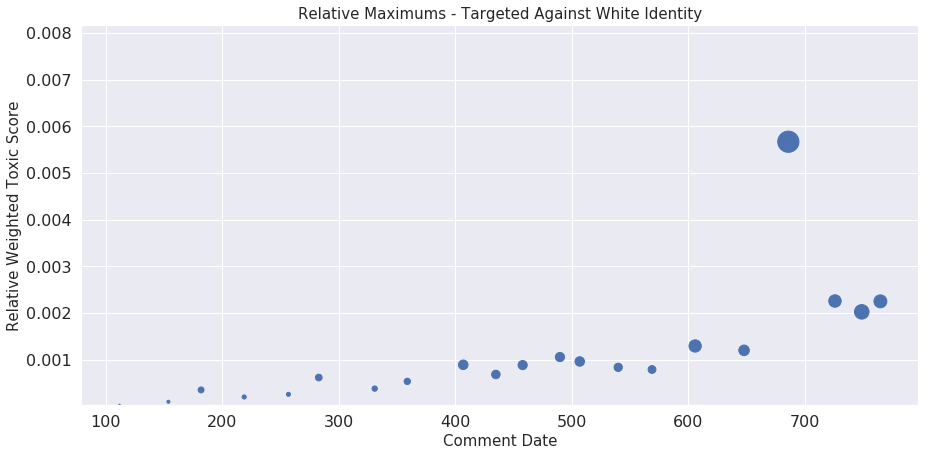

In [51]:
identity = 'white'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

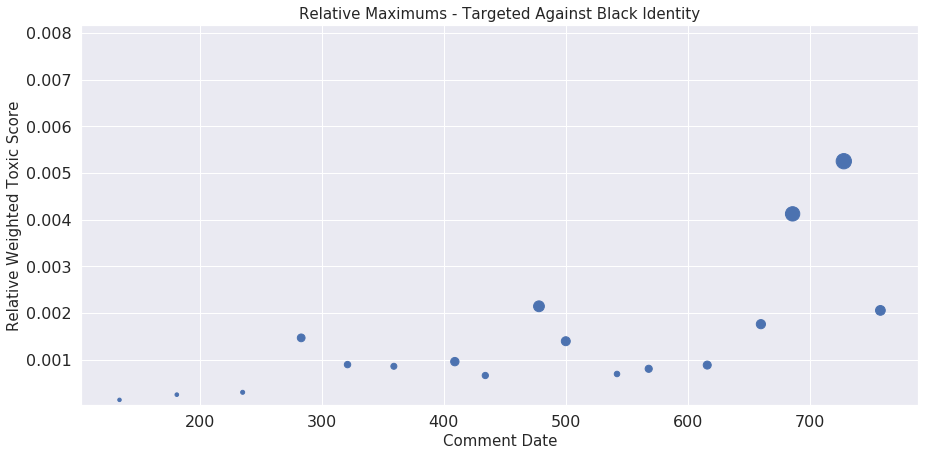

In [52]:
identity = 'black'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

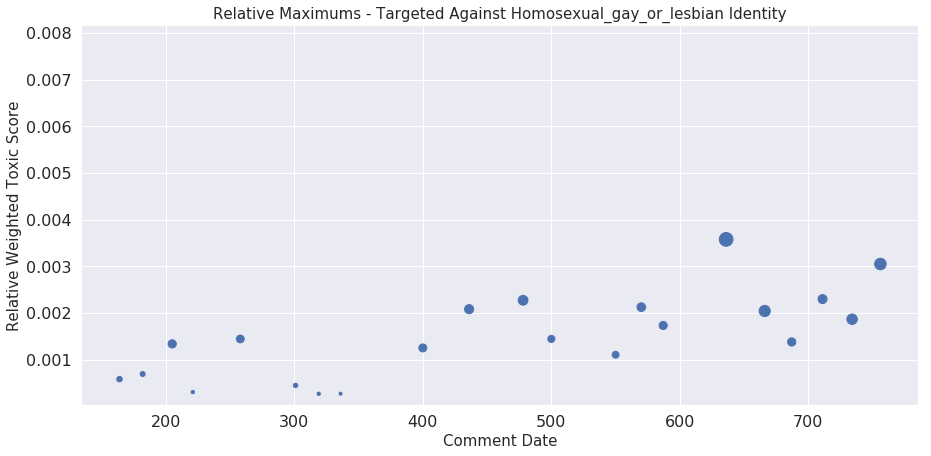

In [53]:
identity = 'homosexual_gay_or_lesbian'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

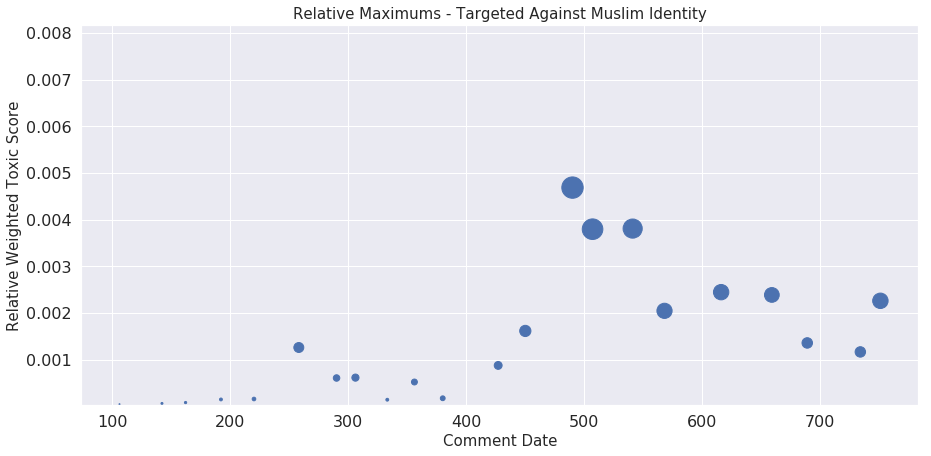

In [54]:
identity = 'muslim'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)

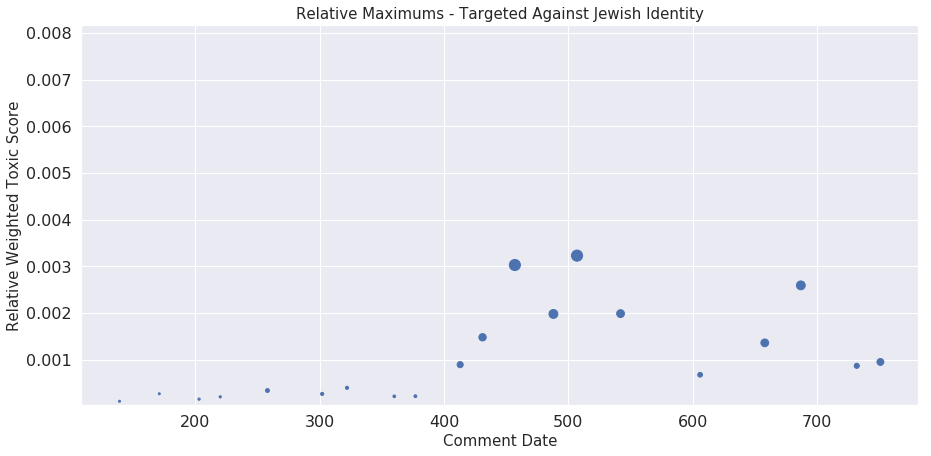

In [55]:
identity = 'jewish'
identity_peaks_df = get_identity_peaks_df(identity, peaks_df, comments_with_date_df)
identity_scatter_plot(identity, identity_peaks_df, y_lim_min, y_lim_max)